In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt


def simulate_loop_average_length(K, termination_probability, num_simulations=1000):
    """
    Simulate loops of length K with termination probability p and compute the average length.

    Parameters:
    - K: The length of the loop.
    - termination_probability: The termination probability (p).
    - num_simulations: The number of simulations to perform.

    Returns:
    - average_length: The average length of the loop.
    """

    total_length = 0

    for _ in range(num_simulations):
        loop_length = 1

        # Simulate the loop termination with probability p
        while random.random() > termination_probability:
            loop_length += 1

            # Ensure termination after reaching the maximum length K
            if loop_length == K:
                break

        total_length += loop_length

    average_length = total_length / num_simulations
    return average_length

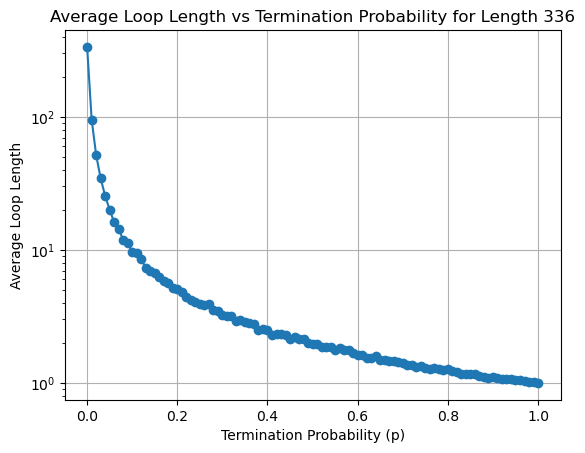

In [6]:
# Example usage:
K = 24 * 14  # Set the length of the loop
probabilities = np.arange(0, 1.01, 0.01)
average_lengths = []

for p in probabilities:
    average_length = simulate_loop_average_length(K, p)
    average_lengths.append(average_length)
    # print(f"Average length of the loop for termination probability {p}: {average_length}")

# Plotting
plt.plot(probabilities, average_lengths, marker="o")
plt.xlabel("Termination Probability (p)")
plt.ylabel("Average Loop Length")
plt.title(f"Average Loop Length vs Termination Probability for Length {K}")
plt.grid(True)
plt.yscale("log")

In [28]:
def estimate_average_length(probability, max_length=100, num_simulations=1000):
    """
    Simulate for-loops of length max_length with termination probability p and compute the average length.

    Parameters:
    - max_length: The length of the loop.
    - termination_probability: The termination probability (p).
    - num_simulations: The number of simulations to perform.

    Returns:
    - average_length: The average length of the loop.
    """

    total_length = 0

    for _ in range(num_simulations):
        loop_length = 1

        # Simulate the loop termination with probability p
        while random.random() > probability and loop_length < max_length:
            loop_length += 1

        total_length += loop_length

    average_length = total_length / num_simulations
    return average_length

In [29]:
estimate_average_length(0.5)

1.997

In [32]:
import math

import torch
import torch.nn.functional as F
from timm.models.layers.helpers import to_2tuple
from torch import nn


def _get_conv2d_weights(
    in_channels,
    out_channels,
    kernel_size,
):
    weight = torch.empty(out_channels, in_channels, *kernel_size)
    return weight


def _get_conv2d_biases(out_channels):
    bias = torch.empty(out_channels)
    return bias


class ParallelVarPatchEmbed(nn.Module):
    """Variable to Patch Embedding with multiple variables in a single kernel. Key idea is to use Grouped Convolutions.

    Args:
        max_vars (int): Maximum number of variables
        img_size (int): Image size
        patch_size (int): Patch size
        embed_dim (int): Embedding dimension
        norm_layer (nn.Module, optional): Normalization layer. Defaults to None.
        flatten (bool, optional): Flatten the output. Defaults to True.
    """

    def __init__(
        self,
        max_vars: int,
        img_size,
        patch_size,
        embed_dim,
        norm_layer=None,
        flatten=True,
    ):
        super().__init__()
        self.max_vars = max_vars
        self.img_size = to_2tuple(img_size)
        self.patch_size = to_2tuple(patch_size)
        self.grid_size = (
            img_size[0] // self.patch_size[0],
            img_size[1] // self.patch_size[1],
        )
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten

        grouped_weights = torch.stack(
            [
                _get_conv2d_weights(1, embed_dim, self.patch_size)
                for _ in range(max_vars)
            ],
            dim=0,
        )
        self.proj_weights = nn.Parameter(grouped_weights)
        grouped_biases = torch.stack(
            [_get_conv2d_biases(embed_dim) for _ in range(max_vars)], dim=0
        )
        self.proj_biases = nn.Parameter(grouped_biases)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()
        self.reset_parameters()

    def reset_parameters(self):
        for idx in range(self.max_vars):
            nn.init.kaiming_uniform_(self.proj_weights[idx], a=math.sqrt(5))
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.proj_weights[idx])
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(self.proj_biases[idx], -bound, bound)

    def forward(self, x, vars=None):
        B, C, H, W = x.shape
        if vars is None:
            vars = range(self.max_vars)
        weights = self.proj_weights[vars].flatten(0, 1)
        biases = self.proj_biases[vars].flatten(0, 1)

        groups = len(vars)
        proj = F.conv2d(x, weights, biases, groups=groups, stride=self.patch_size)
        if self.flatten:
            proj = proj.reshape(B, groups, -1, *proj.shape[-2:])
            proj = proj.flatten(3).transpose(2, 3)

        proj = self.norm(proj)
        return proj

In [33]:
# Assume you have an input tensor x with shape (B, C, H, W)
x = torch.randn(1, 67, 640, 1280)  # Example input shape, adjust accordingly

# Initialize ParallelVarPatchEmbed
max_vars = 67
img_size = (640, 1280)
patch_size = (16, 16)
embed_dim = 64

# Create an instance of ParallelVarPatchEmbed
patch_embed = ParallelVarPatchEmbed(
    max_vars, img_size, patch_size, embed_dim, norm_layer=nn.LayerNorm, flatten=True
)

# Forward pass
output = patch_embed(x)

# Display the shapes of input and output
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([1, 67, 640, 1280])
Output shape: torch.Size([1, 67, 3200, 64])
